<a href="https://colab.research.google.com/github/alphaczar/Deep-Learning/blob/master/EmergencyVsNonEmergency_fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.vision import *
from fastai.metrics import error_rate

In [4]:
#tfms= get_transforms(do_flip=True,flip_vert=True,max_rotate=50,max_lighting=0.1,max_warp=0 )

In [4]:
path = '/content/drive/My Drive/EmergencyNonEmergency'
data = ImageDataBunch.from_folder(path, train='train_images', test='test_images',seed =1,valid_pct=0.2)

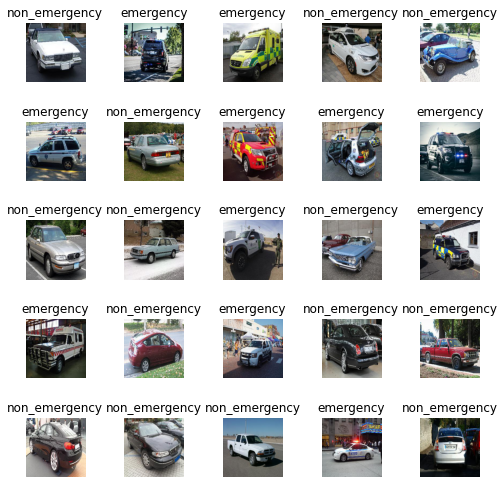

In [6]:
data.show_batch(row=3, figsize=(7, 7))

In [7]:
print(data.classes)
len(data.classes), data.c

['emergency', 'non_emergency']


(2, 2)

In [5]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [9]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [6]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.645815,0.250976,0.085106,09:48
1,0.402719,0.294800,0.075988,00:18
2,0.265368,0.283211,0.091185,00:06
3,0.195631,0.264876,0.079027,00:06


In [7]:
learn.save('stage-1')

In [8]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
len(data.valid_ds) == len(losses) == len(idxs)

True

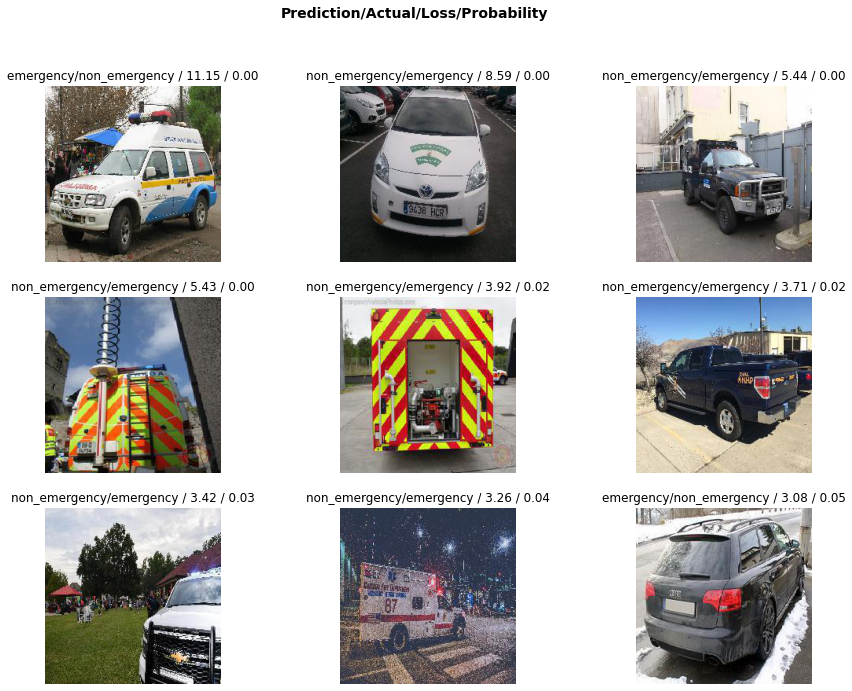

In [9]:
interp.plot_top_losses(9, figsize=(15,11))

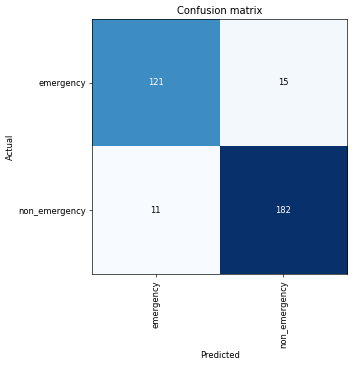

In [10]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

In [16]:
interp.most_confused(min_val=2)

[('emergency', 'non_emergency', 16), ('non_emergency', 'emergency', 8)]

In [11]:
learn.unfreeze()

In [12]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.345594,0.461629,0.100304,00:07


In [13]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (1317 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
emergency,emergency,emergency,emergency,emergency
Path: /content/drive/My Drive/EmergencyNonEmergency;

Valid: LabelList (329 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
emergency,non_emergency,non_emergency,emergency,non_emergency
Path: /content/drive/My Drive/EmergencyNonEmergency;

Test: LabelList (706 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /content/drive/My Drive/EmergencyNonEmergency, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

In [14]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


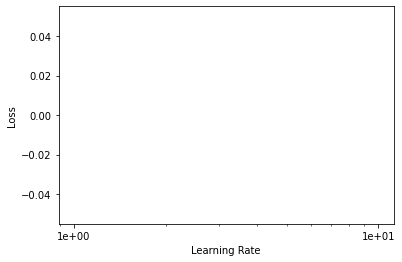

In [15]:
learn.recorder.plot()

In [16]:
learn.fit_one_cycle(10,max_lr=slice(1e-4,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.070643,0.229563,0.069909,00:06
1,0.066256,0.505170,0.094225,00:06
2,0.066092,0.584855,0.103343,00:06
3,0.082276,0.300294,0.094225,00:06
4,0.085417,0.339188,0.063830,00:06
5,0.069616,0.229615,0.042553,00:06
6,0.052971,0.232501,0.054711,00:06
7,0.038883,0.232831,0.051672,00:06
8,0.029136,0.227305,0.054711,00:06
9,0.022982,0.231984,0.054711,00:07


In [23]:

learn.freeze()
learn.save('emergency_classification')

In [44]:
import pandas as pd
# #path = '/content/drive/My Drive/EmergencyNonEmergency'
sub_file = pd.read_csv('/content/drive/My Drive/EmergencyNonEmergency/test_images_actual_label.csv')
sub_file.head()

,image_names,emergency_or_not
0,100.jpg,1
1,105.jpg,1
2,109.jpg,1
3,111.jpg,1
4,115.jpg,1


In [29]:
predictions, *_ = learn.get_preds(DatasetType.Test)
labels = np.argmax(predictions, 1)
labels = labels.numpy()


In [49]:
sub_file['res_34_preds']  = labels

In [51]:
sub_file.head()
sub_file.to_csv('submission.csv', header=True, index=False)